# Problem statement

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The **business objective** is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.


# Required imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',230)

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

# Reading the data

In [2]:
#Reading the dataset
tele = pd.read_csv("telecom_churn_data.csv")

tele.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [3]:
tele.shape

(99999, 226)

# Feature engineering to filter high value customers

In [4]:
#Deriving the total recharge amount for four months and for good phase. This will help in filtering high value customers
tele["total_rech_amt_good_phase"] = (tele["total_rech_amt_6"] + tele["total_rech_amt_7"])/2

print(tele["total_rech_amt_good_phase"].describe(percentiles=[0.05,.25, .5, .7, .75, .90, .95, .99]))

# We will take the customers above the 70th percentile
percentile_70 = tele["total_rech_amt_good_phase"].quantile([0.0,0.7]).values

print(percentile_70[0])
print(percentile_70[1])


count    99999.000000
mean       325.238792
std        370.833466
min          0.000000
5%          30.000000
25%        115.000000
50%        229.000000
70%        368.500000
75%        419.000000
90%        698.000000
95%        937.500000
99%       1590.000000
max      37762.500000
Name: total_rech_amt_good_phase, dtype: float64
0.0
368.5


# Filter high value customers

In [5]:
high_tele=tele[tele["total_rech_amt_good_phase"] > percentile_70[1]].copy()
high_tele.shape

(29979, 227)

In [6]:
#checking NULL value percentages of all columns
for column in high_tele.columns:
    print(column+" "+str(round(100 * (high_tele[column].isnull().sum()/len(high_tele[column].index)), 2)))

mobile_number 0.0
circle_id 0.0
loc_og_t2o_mou 0.38
std_og_t2o_mou 0.38
loc_ic_t2o_mou 0.38
last_date_of_month_6 0.0
last_date_of_month_7 0.1
last_date_of_month_8 0.52
last_date_of_month_9 1.2
arpu_6 0.0
arpu_7 0.0
arpu_8 0.0
arpu_9 0.0
onnet_mou_6 1.05
onnet_mou_7 1.01
onnet_mou_8 3.13
onnet_mou_9 5.68
offnet_mou_6 1.05
offnet_mou_7 1.01
offnet_mou_8 3.13
offnet_mou_9 5.68
roam_ic_mou_6 1.05
roam_ic_mou_7 1.01
roam_ic_mou_8 3.13
roam_ic_mou_9 5.68
roam_og_mou_6 1.05
roam_og_mou_7 1.01
roam_og_mou_8 3.13
roam_og_mou_9 5.68
loc_og_t2t_mou_6 1.05
loc_og_t2t_mou_7 1.01
loc_og_t2t_mou_8 3.13
loc_og_t2t_mou_9 5.68
loc_og_t2m_mou_6 1.05
loc_og_t2m_mou_7 1.01
loc_og_t2m_mou_8 3.13
loc_og_t2m_mou_9 5.68
loc_og_t2f_mou_6 1.05
loc_og_t2f_mou_7 1.01
loc_og_t2f_mou_8 3.13
loc_og_t2f_mou_9 5.68
loc_og_t2c_mou_6 1.05
loc_og_t2c_mou_7 1.01
loc_og_t2c_mou_8 3.13
loc_og_t2c_mou_9 5.68
loc_og_mou_6 1.05
loc_og_mou_7 1.01
loc_og_mou_8 3.13
loc_og_mou_9 5.68
std_og_t2t_mou_6 1.05
std_og_t2t_mou_7 1.01
std

In [7]:
#Remove the columns which have more than 60% of data missing
high_tele = high_tele.drop(high_tele.loc[:,list((100*(high_tele.isnull().sum()/len(high_tele.index)) > 60))].columns, 1)

In [8]:
#Remove those rows who have > 5 NaNs
high_tele = high_tele.loc[high_tele.isnull().sum(axis=1) < 5]

In [9]:
high_tele.isnull().sum()

mobile_number                  0
circle_id                      0
loc_og_t2o_mou                 0
std_og_t2o_mou                 0
loc_ic_t2o_mou                 0
last_date_of_month_6           0
last_date_of_month_7           0
last_date_of_month_8           0
last_date_of_month_9           0
arpu_6                         0
arpu_7                         0
arpu_8                         0
arpu_9                         0
onnet_mou_6                    0
onnet_mou_7                    0
onnet_mou_8                    0
onnet_mou_9                    0
offnet_mou_6                   0
offnet_mou_7                   0
offnet_mou_8                   0
offnet_mou_9                   0
roam_ic_mou_6                  0
roam_ic_mou_7                  0
roam_ic_mou_8                  0
roam_ic_mou_9                  0
roam_og_mou_6                  0
roam_og_mou_7                  0
roam_og_mou_8                  0
roam_og_mou_9                  0
loc_og_t2t_mou_6               0
loc_og_t2t

In [10]:
high_tele.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_good_phase
count,2.796000e+04,27960.0,27960.0,27960.0,27960.0,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.0,27960.0,27960.0,27960.0,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.000000,27960.0,27960

In [11]:
# Columns that have only 0 or null values along with index columns
drop_cols=['mobile_number','circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6',
          'std_og_t2c_mou_7','std_og_t2c_mou_8','std_og_t2c_mou_9','std_ic_t2o_mou_6','std_ic_t2o_mou_7',
          'std_ic_t2o_mou_8','std_ic_t2o_mou_9']

In [12]:
#Dropping irrelevant columns
high_tele = high_tele.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9','last_day_rch_amt_6',
                           'last_day_rch_amt_7','last_day_rch_amt_8','last_day_rch_amt_9','last_date_of_month_6','last_date_of_month_7',
                           'last_date_of_month_8','last_date_of_month_9'],axis=1)

In [13]:
high_tele.drop(drop_cols,axis=1,inplace=True)
high_tele.shape

(27960, 162)

In [14]:
#checking NULL value percentages of all columns, again
for column in high_tele.columns:
    print(column+" "+str(round(100 * (high_tele[column].isnull().sum()/len(high_tele[column].index)), 2)))

arpu_6 0.0
arpu_7 0.0
arpu_8 0.0
arpu_9 0.0
onnet_mou_6 0.0
onnet_mou_7 0.0
onnet_mou_8 0.0
onnet_mou_9 0.0
offnet_mou_6 0.0
offnet_mou_7 0.0
offnet_mou_8 0.0
offnet_mou_9 0.0
roam_ic_mou_6 0.0
roam_ic_mou_7 0.0
roam_ic_mou_8 0.0
roam_ic_mou_9 0.0
roam_og_mou_6 0.0
roam_og_mou_7 0.0
roam_og_mou_8 0.0
roam_og_mou_9 0.0
loc_og_t2t_mou_6 0.0
loc_og_t2t_mou_7 0.0
loc_og_t2t_mou_8 0.0
loc_og_t2t_mou_9 0.0
loc_og_t2m_mou_6 0.0
loc_og_t2m_mou_7 0.0
loc_og_t2m_mou_8 0.0
loc_og_t2m_mou_9 0.0
loc_og_t2f_mou_6 0.0
loc_og_t2f_mou_7 0.0
loc_og_t2f_mou_8 0.0
loc_og_t2f_mou_9 0.0
loc_og_t2c_mou_6 0.0
loc_og_t2c_mou_7 0.0
loc_og_t2c_mou_8 0.0
loc_og_t2c_mou_9 0.0
loc_og_mou_6 0.0
loc_og_mou_7 0.0
loc_og_mou_8 0.0
loc_og_mou_9 0.0
std_og_t2t_mou_6 0.0
std_og_t2t_mou_7 0.0
std_og_t2t_mou_8 0.0
std_og_t2t_mou_9 0.0
std_og_t2m_mou_6 0.0
std_og_t2m_mou_7 0.0
std_og_t2m_mou_8 0.0
std_og_t2m_mou_9 0.0
std_og_t2f_mou_6 0.0
std_og_t2f_mou_7 0.0
std_og_t2f_mou_8 0.0
std_og_t2f_mou_9 0.0
std_og_mou_6 0.0
std_og_

# Tag churners

In [15]:
#A customer will churn if they stop calling and stop using internet and other services
high_tele['churn'] = high_tele['total_ic_mou_9'] + high_tele['total_og_mou_9'] + high_tele['vol_2g_mb_9'] + high_tele['vol_3g_mb_9']

high_tele['churn'] = high_tele['churn'].apply(lambda x: 0 if x > 0 else 1)

high_tele['churn'].value_counts()

0    27014
1      946
Name: churn, dtype: int64

# Exploratory Data Analysis (EDA)

## Analyze churn vs non-churn data

In [16]:
churns = high_tele.loc[high_tele['churn'] == 1]
nonchurns = high_tele.loc[high_tele['churn'] == 0]

def plotFig(feature, df, label):
    f, ax = plt.subplots(figsize=(10, 3))
    for i in range(6,10):        
        column="{}_{}".format(feature, i)
        sns.distplot(df[column], hist=False, label=column)
#         print(df[column].skew(),'skewness',i)
#         print(df[column].kurtosis(), 'kurtosis',i)
    ax.set(xlabel="{}_{}".format(feature, label))
    plt.legend();

https://www.analyticsvidhya.com/blog/2021/05/shape-of-data-skewness-and-kurtosis/

### Incoming and outgoing calls analysis for churns

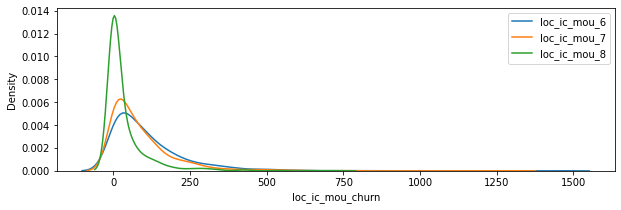

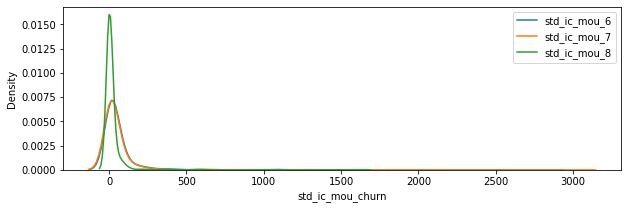

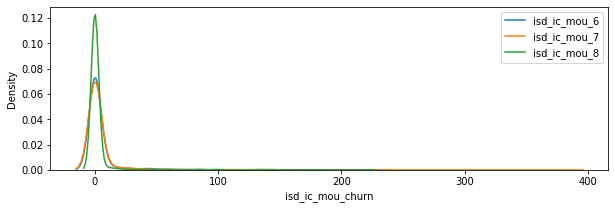

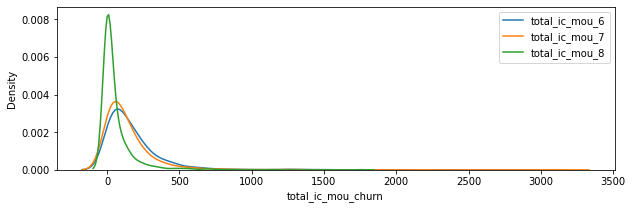

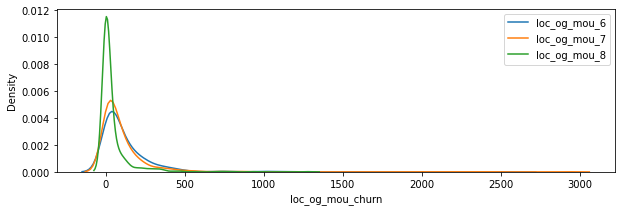

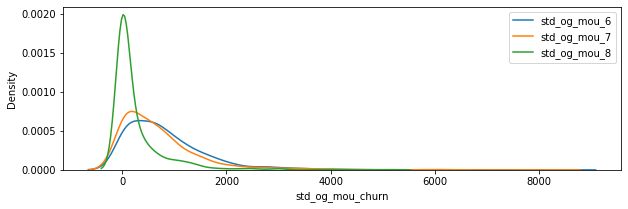

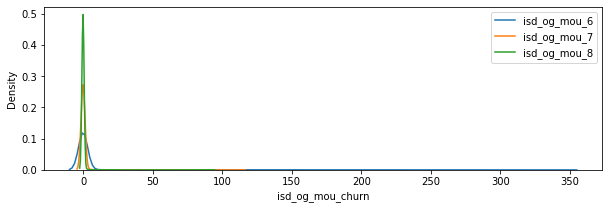

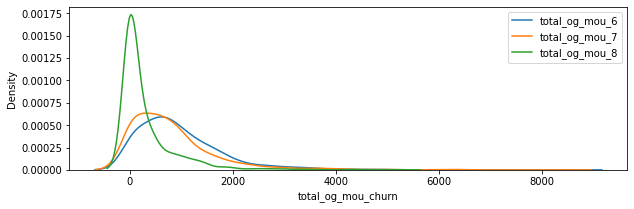

In [17]:
#ic mou plots for churns
plotFig('loc_ic_mou', churns, 'churn')
plotFig('std_ic_mou', churns, 'churn')
plotFig('isd_ic_mou', churns, 'churn')
plotFig('total_ic_mou', churns, 'churn')

# og plots mou for churns
plotFig('loc_og_mou', churns, 'churn')
plotFig('std_og_mou', churns, 'churn')
plotFig('isd_og_mou', churns, 'churn')
plotFig('total_og_mou', churns, 'churn')

**Observations**
- There is a drop in incoming and outgoing calls in 3 months

### Incoming and outgoing calls analysis for non-churns

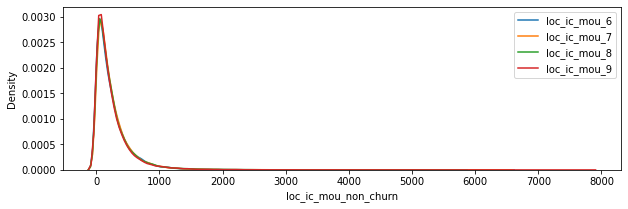

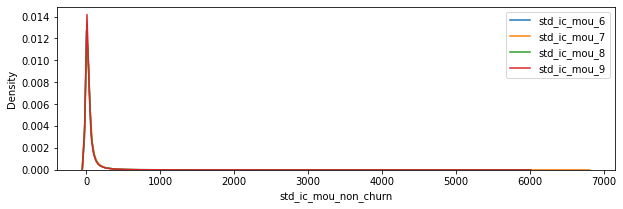

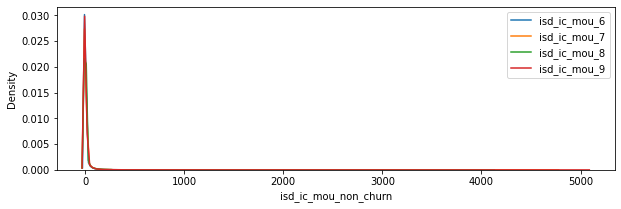

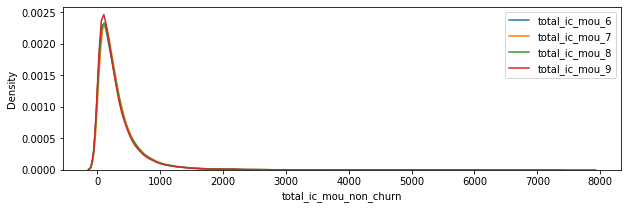

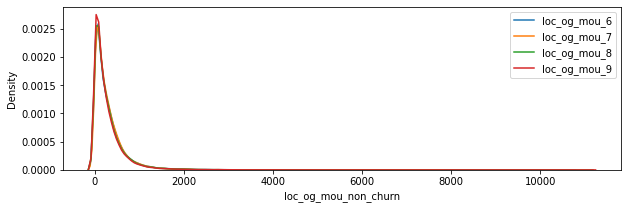

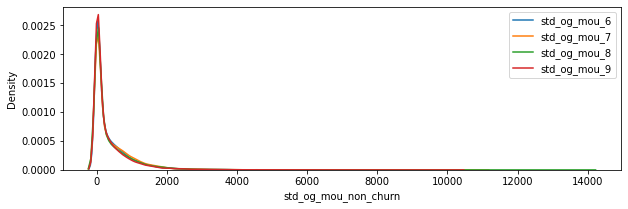

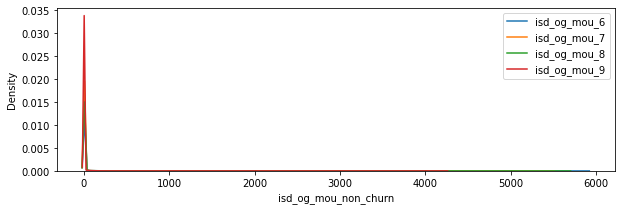

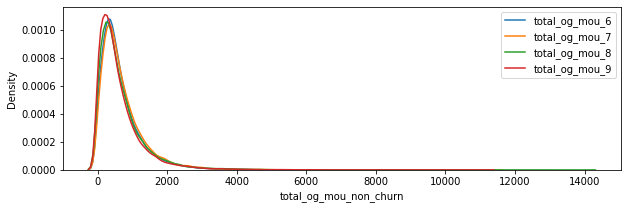

In [18]:
# ic plots for non-churns
plotFig('loc_ic_mou', nonchurns, 'non_churn')
plotFig('std_ic_mou', nonchurns, 'non_churn')
plotFig('isd_ic_mou', nonchurns, 'non_churn')
plotFig('total_ic_mou', nonchurns, 'non_churn')

# og plots for non-churns
plotFig('loc_og_mou', nonchurns, 'non_churn')
plotFig('std_og_mou', nonchurns, 'non_churn')
plotFig('isd_og_mou', nonchurns, 'non_churn')
plotFig('total_og_mou', nonchurns, 'non_churn')

**Observations**
- For non churns, the incoming and outgoing calls seem constant throughtout the months

### 2G & 3G volume analysis for churns

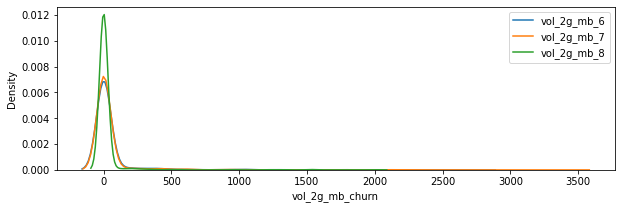

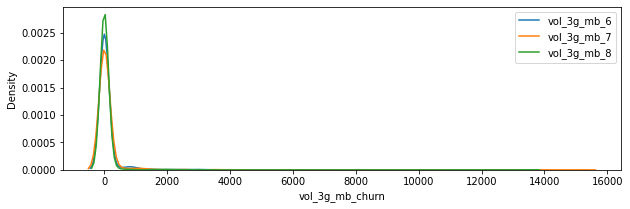

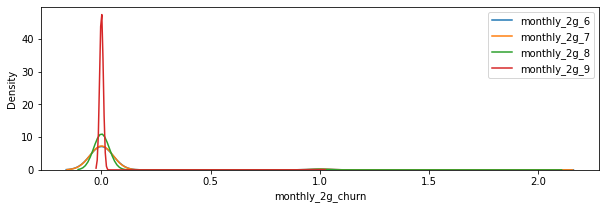

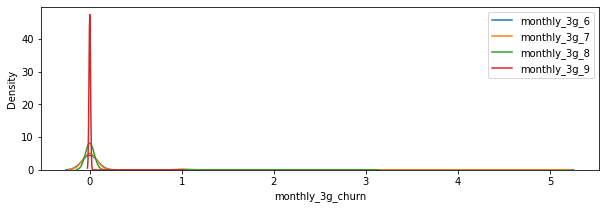

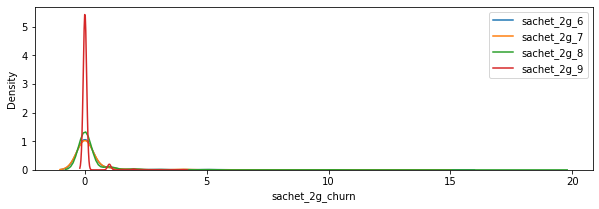

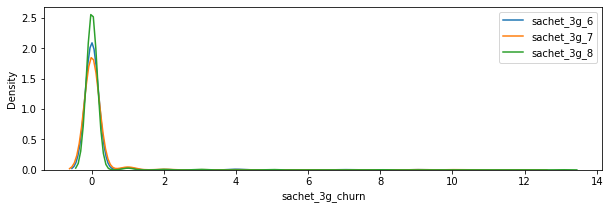

In [19]:
plotFig('vol_2g_mb', churns, 'churn')
plotFig('vol_3g_mb', churns, 'churn')
plotFig('monthly_2g', churns, 'churn')
plotFig('monthly_3g', churns, 'churn')
plotFig('sachet_2g', churns, 'churn')
plotFig('sachet_3g', churns, 'churn')

### 2G & 3G volume analysis for churns

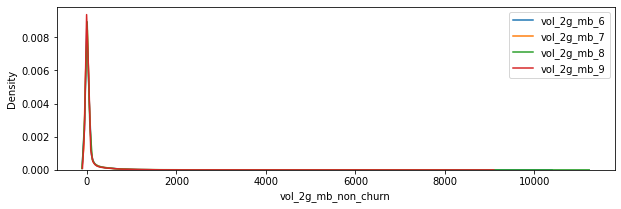

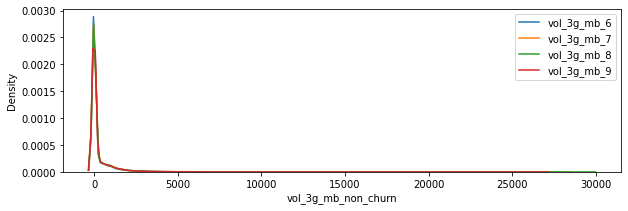

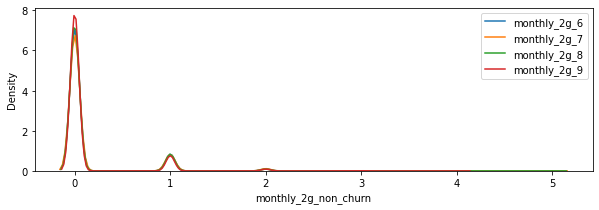

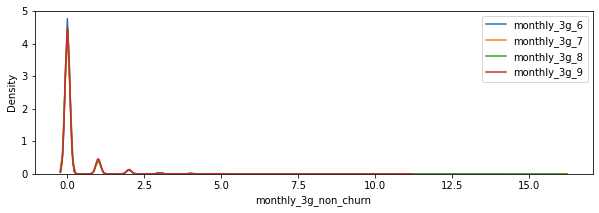

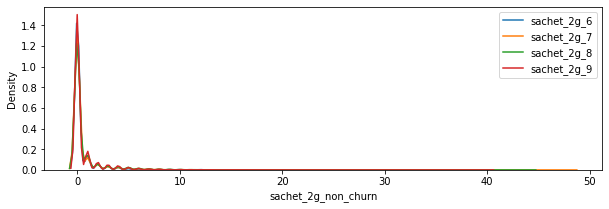

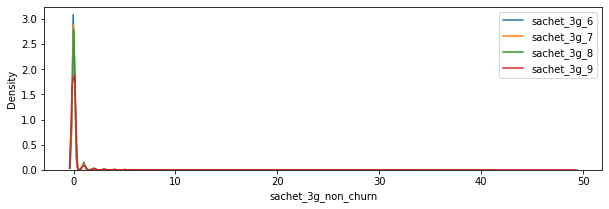

In [20]:
plotFig('vol_2g_mb', nonchurns, 'non_churn')
plotFig('vol_3g_mb', nonchurns, 'non_churn')
plotFig('monthly_2g', nonchurns, 'non_churn')
plotFig('monthly_3g', nonchurns, 'non_churn')
plotFig('sachet_2g', nonchurns, 'non_churn')
plotFig('sachet_3g', nonchurns, 'non_churn')

### Recharge amount analysis for churns

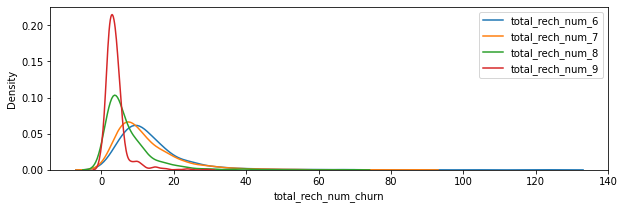

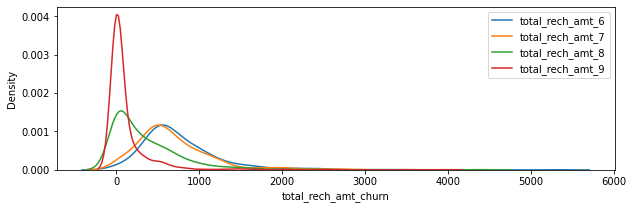

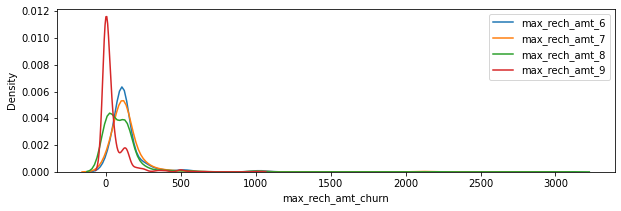

In [21]:
plotFig('total_rech_num', churns, 'churn')
plotFig('total_rech_amt', churns, 'churn')
plotFig('max_rech_amt', churns, 'churn')

### Recharge amount analysis for churns

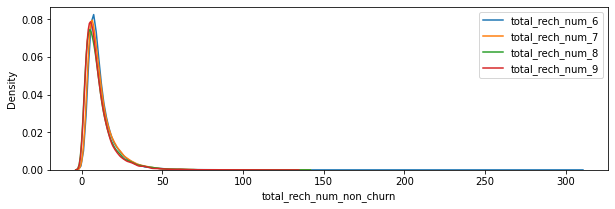

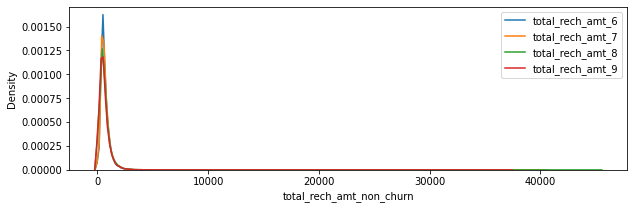

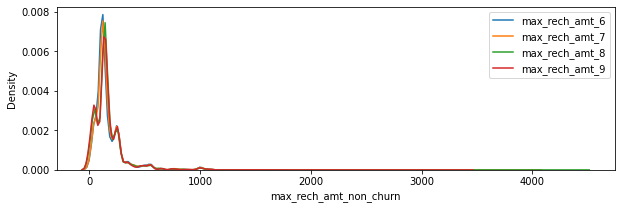

In [22]:
plotFig('total_rech_num', nonchurns, 'non_churn')
plotFig('total_rech_amt', nonchurns, 'non_churn')
plotFig('max_rech_amt', nonchurns, 'non_churn')

### ARPU for churns vs non churns

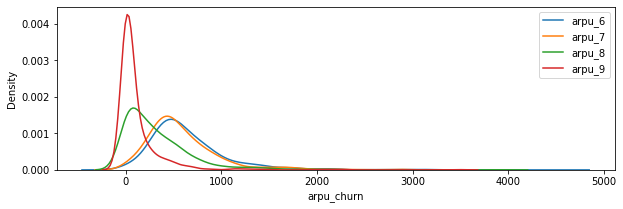

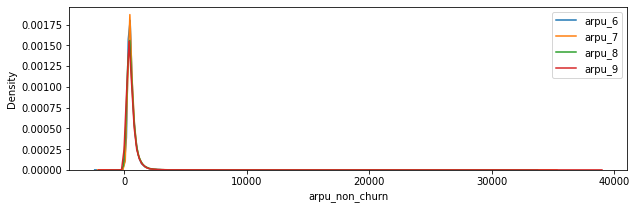

In [23]:
plotFig('arpu', churns, 'churn')
plotFig('arpu', nonchurns, 'non_churn')

https://www.kaggle.com/pranay969/telecom-churn<br>

https://www.kaggle.com/rahulbhargava21/telecom-churn-case-study

In [24]:
# Dropping columns related to 9th month
for col in high_tele.columns:
    if col.find('_9')!=-1:
#         print(col)
        high_tele=high_tele.drop(col,1)
    
# Also dropping the Sep column
high_tele=high_tele.drop('sep_vbc_3g',axis=1)

In [25]:
high_tele.shape

(27960, 123)

In [26]:
high_tele['change_offnet_mou']=(high_tele['offnet_mou_8']-high_tele[['offnet_mou_6','offnet_mou_7']].mean(axis=1))/high_tele[['offnet_mou_6','offnet_mou_7']].mean(axis=1)

In [27]:
# Checking percentage change from good phase to action phase
def createDerivedFeature(df, feature):
    newFeature = 'change_' + feature
    
    feature6 = feature + '_6'
    feature7 = feature + '_7'
    feature8 = feature + '_8'
    
    feature_active_avg = df[[feature6, feature7,feature8]].mean(axis=1)
    df[newFeature] = ((df[feature8] -  df[[feature6, feature7]].mean(axis=1)) / feature_active_avg)
                   
    df.drop([feature6, feature7, feature8], axis=1, inplace=True)

In [28]:
high_tele.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'total_rech_amt_good_phase', 'churn',
       'change_offnet_mou'],
      dtype='object', length=124)

In [29]:
# Creating derived columns for incoming columns
ic_derived=['loc_ic_t2t_mou','loc_ic_t2m_mou','loc_ic_t2f_mou','loc_ic_mou','std_ic_t2t_mou','std_ic_t2m_mou','std_ic_t2f_mou',
           'std_ic_mou','spl_ic_mou','isd_ic_mou','ic_others','roam_ic_mou','total_ic_mou']

for i in ic_derived:
    createDerivedFeature(high_tele,i)

In [30]:
# Creating derived columns for outgoing columns
og_derived=['loc_og_t2t_mou','loc_og_t2m_mou','loc_og_t2f_mou','loc_og_t2c_mou','loc_og_mou','std_og_t2t_mou','std_og_t2m_mou',
           'std_og_t2f_mou','std_og_mou','spl_og_mou','isd_og_mou','og_others','roam_og_mou','total_og_mou','onnet_mou','offnet_mou']
for i in og_derived:
    createDerivedFeature(high_tele,i)

In [31]:
# Creating derived columns for 2g/3g data
data_2g_3g=['vol_2g_mb','vol_3g_mb','monthly_2g','monthly_3g','sachet_2g','sachet_3g']
for i in data_2g_3g:
    createDerivedFeature(high_tele,i)

In [32]:
# Creating derived columns for total recharge and revenue

rev=['total_rech_num','max_rech_amt','total_rech_amt','arpu']
for i in rev:
    createDerivedFeature(high_tele,i)


In [33]:
# Changing names of some columns as per our convenience
high_tele['vbc_3g_6'] = high_tele['jun_vbc_3g']
high_tele['vbc_3g_7'] = high_tele['jul_vbc_3g']
high_tele['vbc_3g_8'] = high_tele['aug_vbc_3g']
createDerivedFeature(high_tele, 'vbc_3g')
high_tele.drop(['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g'], axis=1, inplace=True)

In [34]:
high_tele.shape

(27960, 43)

In [35]:
high_tele=high_tele.fillna(0)
high_tele=high_tele.replace(np.inf,0)

In [36]:
high_tele

,aon,total_rech_amt_good_phase,churn,change_offnet_mou,change_loc_ic_t2t_mou,change_loc_ic_t2m_mou,change_loc_ic_t2f_mou,change_loc_ic_mou,change_std_ic_t2t_mou,change_std_ic_t2m_mou,change_std_ic_t2f_mou,change_std_ic_mou,change_spl_ic_mou,change_isd_ic_mou,change_ic_others,change_roam_ic_mou,change_total_ic_mou,change_loc_og_t2t_mou,change_loc_og_t2m_mou,change_loc_og_t2f_mou,change_loc_og_t2c_mou,change_loc_og_mou,change_std_og_t2t_mou,change_std_og_t2m_mou,change_std_og_t2f_mou,change_std_og_mou,change_spl_og_mou,change_isd_og_mou,change_og_others,change_roam_og_mou,change_total_og_mou,change_onnet_mou,change_vol_2g_mb,change_vol_3g_mb,change_monthly_2g,change_monthly_3g,change_sachet_2g,change_sachet_3g,change_total_rech_num,change_max_rech_amt,change_total_rech_amt,change_arpu,change_vbc_3g
8,315,519.0,0,0.469914,-1.458959,-0.699678,0.000000,-0.913011,-0.838235,-1.392305,0.000000,-1.378772,0.0,0.000000,0.000000,0.000000,-1.000101,-1.393392,-0.374555,0.000000,3.000000,-1.111030,-1.127215,1.925920,0.0,-0.311193,3.000000,0.0,0.0,0.000000,-0.805475,-1.302626,-1.499621,-1.429570,-1.50,0.000000,1.875,0.0,-0.333333,-1.007299,-1.033679,-0.886963,-1.410200
13,2607,380.0,0,0.638880,0.347938,0.963081,1.240244,0.811440,0.754448,0.681350,3.000000,0.709275,-1.5,1.026121,-0.703698,-0.147261,0.753288,0.264619,1.188478,2.271658,3.000000,1.099554,0.675424,0.017991,0.0,0.470940,3.000000,3.0,0.0,-1.354969,0.660373,0.600752,3.000000,0.000000,0.00,0.000000,3.000,0.0,0.857143,0.171429,0.684496,0.566665,0.000000
16,511,459.0,0,-0.436657,-0.582274,-0.216971,1.438024,-0.173556,-1.314744,0.507876,2.146840,-0.348460,0.0,3.000000,0.000000,-1.500000,-0.226971,0.231145,-0.445759,1.632293,0.000000,-0.243444,-0.439051,-0.721996,0.0,-0.689315,1.400218,0.0,0.0,-1.500000,-0.287566,0.128376,0.000000,0.000000,0.00,0.000000,0.000,0.0,-1.000000,0.171429,-0.832096,-0.579691,-1.500000
17,667,408.0,0,-1.128907,-1.500000,-1.500000,0.000000,-1.500000,-1.500000,-1.500000,0.000000,-1.500000,0.0,0.000000,0.000000,0.761755,-1.500000,-1.500000,-1.500000,0.000000,0.000000,-1.500000,-1.500000,-1.500000,0.0,-1.500000,-1.500000,0.0,-1.5,1.253670,-1.500000,-1.470860,0.000000,0.000000,0.00,0.000000,0.000,0.0,-0.780000,-0.535714,-1.340426,-1.343775,0.000000
21,720,640.0,0,0.177504,1.229898,0.304919,1.120796,0.424097,-1.459941,0.704710,0.000000,0.512659,0.0,0.000000,0.000000,0.000000,0.457735,1.590936,0.157512,1.551502,0.000000,0.319522,-0.526623,0.178564,0.0,0.102170,0.000000,0.0,0.0,0.000000,0.125749,-0.301445,0.000000,0.000000,0.00,0.000000,0.000,0.0,0.120000,0.000000,0.117117,0.139986,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99970,1022,392.0,0,-0.150304,0.127320,1.163512,-0.227357,0.672871,2.554274,1.008566,0.000000,1.234908,0.0,0.000000,0.692308,-1.500000,0.767491,0.118989,1.193339,2.474453,1.868941,0.470295,1.453569,-0.281072,0.0,-0.228345,1.666163,0.0,0.0,-1.500000,-0.028889,0.291301,0.000000,0.000000,0.00,0.000000,-1.500,0.0,-0.139535,-0.154018,-0.147190,-0.140508,0.000000
99974,3054,465.0,0,-0.096079,-1.306417,-0.542299,-1.123860,-0.603420,0.000000,0.352740,-1.500000,-0.671375,0.0,0.000000,-1.500000,0.000000,-0.616071,-1.500000,-0.056909,-0.694991,-0.948113,-0.073143,3.000000,-0.976270,-1.5,-0.980963,-0.150953,0.0,-1.5,0.000000,-0.118512,-1.189820,0.000000,0.000000,0.00,0.000000,0.000,0.0,-0.750000,0.081081,-0.175266,0.008997,0.000000
99986,2696,848.5,0,-0.158469,0.197234,0.033057,0.092744,0.071976,-1.500000,1.393031,-0.863208,1.065361,0.0,-1.500000,0.000000,0.000000,0.094210,0.180702,-0.125191,-0.299569,-0.515423,0.036459,-0.267682,-0.274594,0.0,-0.271870,-0.515423,0.0,0.0,0.000000,-0.008638,0.137037,-0.990640,-0.006334,0.00,0.000000,0.000,0.0,-0.705882,-1.417340,-1.434669,0.025653,-0.183375
99988,328,467.0,0,0.093630,-1.372545,1.610141,-0.052273,1.459068,-1.139218,-1.038389,0.357558,-1.038528,0.0,0.000000,1.235294,0.000000,0.

## Class Imbalance

<AxesSubplot:xlabel='churn', ylabel='count'>

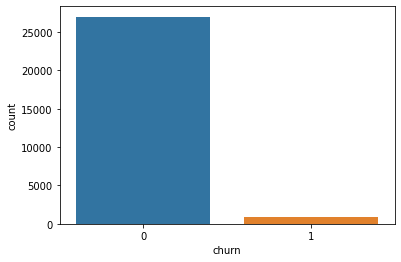

In [37]:
# visualise imbalance
sns.countplot(data=high_tele,x='churn')

### Applying SMOTE Method to deal with class imbalance

In [38]:

y = high_tele.pop('churn')
X = high_tele

In [39]:
smote = SMOTE(random_state=42)
X_blncd, y_blncd = smote.fit_resample(X, y)

In [40]:
X_blncd.shape

(54028, 42)

In [41]:
y_blncd.shape

(54028,)

<AxesSubplot:xlabel='churn', ylabel='count'>

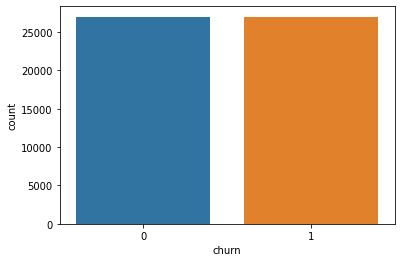

In [42]:
blncd_df=pd.concat([X_blncd,y_blncd],axis=1)
sns.countplot(data=blncd_df,x='churn')

In [43]:
blncd_df['churn'].value_counts(dropna=False)

0    27014
1    27014
Name: churn, dtype: int64

## Splitting into Train-Test

In [44]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(blncd_df, train_size = 0.7, test_size = 0.3, random_state = 42)

## Scaling for Model Building

In [45]:
y_train=df_train.pop('churn')
X_train=df_train

In [46]:
y_test=df_test.pop('churn')
X_test=df_test 

In [47]:
X_train.describe()

,aon,total_rech_amt_good_phase,change_offnet_mou,change_loc_ic_t2t_mou,change_loc_ic_t2m_mou,change_loc_ic_t2f_mou,change_loc_ic_mou,change_std_ic_t2t_mou,change_std_ic_t2m_mou,change_std_ic_t2f_mou,change_std_ic_mou,change_spl_ic_mou,change_isd_ic_mou,change_ic_others,change_roam_ic_mou,change_total_ic_mou,change_loc_og_t2t_mou,change_loc_og_t2m_mou,change_loc_og_t2f_mou,change_loc_og_t2c_mou,change_loc_og_mou,change_std_og_t2t_mou,change_std_og_t2m_mou,change_std_og_t2f_mou,change_std_og_mou,change_spl_og_mou,change_isd_og_mou,change_og_others,change_roam_og_mou,change_total_og_mou,change_onnet_mou,change_vol_2g_mb,change_vol_3g_mb,change_monthly_2g,change_monthly_3g,change_sachet_2g,change_sachet_3g,change_total_rech_num,change_max_rech_amt,change_total_rech_amt,change_arpu,change_vbc_3g
count,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000,37819.000000
mean,1103.209762,712.172477,-0.424398,-0.427310,-0.427581,-0.230325,-0.436725,-0.438205,-0.427609,-0.079741,-0.462223,-0.210366,-0.098664,-0.129117,0.547967,-0.440959,-0.447968,-0.459368,-0.170732,-0.098901,-0.467074,-0.474503,-0.490526,-0.059551,-0.506827,-0.221531,-0.053649,-0.323361,0.448035,-0.498700,-0.423174,-0.066452,-0.027468,-0.036856,-0.029879,0.041745,-0.029087,-0.356503,-0.252610,-0.450448,-0.384159,0.014207
std,873.372619,435.177513,0.691528,0.908190,0.810286,1.105114,0.772934,1.134865,1.102194,0.921439,1.019895,0.767121,0.862612,1.008877,1.362196,0.758261,0.903025,0.827607,1.032592,1.160492,0.794420,0.985367,0.985604,0.739466,0.916489,1.255224,0.606769,0.588876,1.371697,0.748886,0.779934,0.867202,0.642400,0.515240,0.514856,0.844438,0.498813,0.487993,0.604751,0.622342,0.590137,0.638527
min,180.000000,369.000000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-1.500000,-5.817996,-1.500000
25%,464.000000,453.030323,-1.001282,-1.255936,-1.151893,-1.147021,-1.134792,-1.470452,-1.424680,-0.242544,-1.364857,-0.264317,-0.229490,-0.720240,0.000000,-1.133763,-1.268093,-1.222203,-0.921807,-0.972757,-1.200015,-1.388771,-1.392536,0.000000,-1.337253,-1.399582,0.000000,-0.457280,-0.187427,-1.206477,-1.084423,-0.244104,0.000000,0.000000,0.000000,0.000000,0.000000,-0.707609,-0.644449,-0.949585,-0.824273,0.000000
50%,800.000000,584.000000,-0.407283,-0.491639,-0.411672,-0.245126,-0.379489,-0.684990,-0.684812,0.000000,-0.683737,0.000000,0.000000,0.000000,0.000000,-0.372967,-0.520894,-0.462574,0.000000,0.000000,-0.441794,-0.565656,-0.653069,0.000000,-0.607170,-0.349769,0.000000,0.000000,0.000000,-0.436226,-0.459616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.365838,-0.056793,-0.376240,-0.309126,0.000000
75%,1472.500000,830.685562,0.045093,0.108822,0.100536,0.021563,0.067092,0.000000,0.069802,0.000000,0.063549,0.000000,0.000000,0.000000,1.597728,0.068038,0.084541,0.071531,0.000000,0.000000,0.052654,0.000000,0.000000,0.000000,0.000000,0.082670,0.000000,0.000000,1.382610,0.018378,0.071971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.016038,0.160322,0.013387,0.040263,0.000000
max,4235.000000,18750.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0000

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled= scaler.fit_transform(X_train)
X_scaled=pd.DataFrame(X_scaled,columns=X_train.columns)

#X_test_scaled_df=pd.DataFrame(X_test_scaled,columns=X_test.columns)

X_scaled.head()

,aon,total_rech_amt_good_phase,change_offnet_mou,change_loc_ic_t2t_mou,change_loc_ic_t2m_mou,change_loc_ic_t2f_mou,change_loc_ic_mou,change_std_ic_t2t_mou,change_std_ic_t2m_mou,change_std_ic_t2f_mou,change_std_ic_mou,change_spl_ic_mou,change_isd_ic_mou,change_ic_others,change_roam_ic_mou,change_total_ic_mou,change_loc_og_t2t_mou,change_loc_og_t2m_mou,change_loc_og_t2f_mou,change_loc_og_t2c_mou,change_loc_og_mou,change_std_og_t2t_mou,change_std_og_t2m_mou,change_std_og_t2f_mou,change_std_og_mou,change_spl_og_mou,change_isd_og_mou,change_og_others,change_roam_og_mou,change_total_og_mou,change_onnet_mou,change_vol_2g_mb,change_vol_3g_mb,change_monthly_2g,change_monthly_3g,change_sachet_2g,change_sachet_3g,change_total_rech_num,change_max_rech_amt,change_total_rech_amt,change_arpu,change_vbc_3g
0,-0.517781,-0.601001,-0.291558,-0.698262,-0.924691,-1.148924,-0.952501,-0.805125,-0.561103,0.086541,-0.651866,0.274232,0.11438,0.127983,0.018653,-0.957191,-0.438462,-0.931374,0.165346,-0.266984,-0.760027,-0.634670,-0.702975,0.080534,-0.669057,-0.028164,0.088419,0.549123,-0.167574,-0.833257,-0.602319,-0.364503,0.042758,0.071532,0.058035,-0.049436,0.058312,-0.899885,-0.369707,-0.515909,-0.410182,-0.02225
1,-0.994102,-0.648416,2.239575,-0.034423,2.627312,-1.148924,1.279377,-0.440711,-0.972973,0.086541,-0.492501,0.274232,0.11438,3.101626,-0.402273,0.045137,1.986699,0.882401,0.165346,0.085225,1.530300,0.356291,3.303870,0.080534,0.429253,0.633312,0.088419,-1.998137,-0.326633,0.526043,0.390023,-0.272329,0.042758,0.071532,0.058035,0.838741,0.058312,0.911375,0.417715,0.968558,0.875245,-0.02225
2,-0.785711,5.800372,-0.994271,-0.933632,-1.046104,-0.945516,-1.084827,-0.737550,-0.769026,0.086541,-0.797142,0.274232,0.11438,0.127983,0.680347,-1.100235,-0.916096,-0.985802,-1.069634,-1.013646,-1.017283,-0.812612,-0.796159,0.080534,-0.838413,-0.839449,0.088419,-1.616411,0.638177,-1.036906,-0.811858,0.076629,0.042758,0.071532,-2.418834,-0.049436,0.058312,-1.650896,-1.677125,-1.271326,-1.263808,-0.02225
3,-0.260156,0.596700,-1.322951,-1.181145,-1.323524,0.208420,-1.375653,-0.935626,-0.972973,0.086541,-1.017546,0.274232,0.11438,0.127983,-0.612121,-1.396689,-1.165025,-1.257416,0.165346,-0.457221,-1.300244,-1.040739,-1.024232,0.080534,-1.083686,-0.787361,0.088419,0.549123,-0.317217,-1.337071,-1.206877,0.076629,0.042758,0.071532,0.058035,-0.049436,0.058312,-1.317965,-0.633697,-1.167708,-1.302730,-0.02225
4,1.816878,-0.283043,1.230518,1.473814,2.023423,2.773621,2.059674,1.021598,0.669689,3.342363,0.900538,0.274232,0.11438,0.127983,-0.642297,1.798887,1.708398,1.783852,3.070693,0.085225,1.906763,0.571431,1.220964,0.080534,1.266937,-1.018532,0.088419,0.549123,-0.470138,1.780196,1.304050,0.076629,0.042758,0.071532,0.058035,-0.049436,0.058312,0.730560,2.402029,0.996618,1.263219,-0.02225


## Feature Selection using RFE

In [49]:
# Running RFE with the output number of the variable equal to 20
logreg = LogisticRegression()

from sklearn.feature_selection import RFE
rfe = RFE(logreg, 20)             
rfe = rfe.fit(X_scaled, y_train)

In [50]:
# Checking columns selected by RFE
rfe_cols=X_scaled.columns[rfe.support_]
rfe_cols

Index(['aon', 'total_rech_amt_good_phase', 'change_offnet_mou',
       'change_loc_ic_t2t_mou', 'change_loc_ic_t2m_mou',
       'change_std_ic_t2t_mou', 'change_roam_ic_mou', 'change_total_ic_mou',
       'change_loc_og_t2m_mou', 'change_loc_og_mou', 'change_std_og_t2t_mou',
       'change_og_others', 'change_roam_og_mou', 'change_total_og_mou',
       'change_vol_3g_mb', 'change_total_rech_num', 'change_max_rech_amt',
       'change_total_rech_amt', 'change_arpu', 'change_vbc_3g'],
      dtype='object')

In [51]:
list(zip(X_scaled.columns,rfe.support_,rfe.ranking_))

[('aon', True, 1),
 ('total_rech_amt_good_phase', True, 1),
 ('change_offnet_mou', True, 1),
 ('change_loc_ic_t2t_mou', True, 1),
 ('change_loc_ic_t2m_mou', True, 1),
 ('change_loc_ic_t2f_mou', False, 21),
 ('change_loc_ic_mou', False, 5),
 ('change_std_ic_t2t_mou', True, 1),
 ('change_std_ic_t2m_mou', False, 13),
 ('change_std_ic_t2f_mou', False, 14),
 ('change_std_ic_mou', False, 12),
 ('change_spl_ic_mou', False, 17),
 ('change_isd_ic_mou', False, 19),
 ('change_ic_others', False, 2),
 ('change_roam_ic_mou', True, 1),
 ('change_total_ic_mou', True, 1),
 ('change_loc_og_t2t_mou', False, 4),
 ('change_loc_og_t2m_mou', True, 1),
 ('change_loc_og_t2f_mou', False, 6),
 ('change_loc_og_t2c_mou', False, 15),
 ('change_loc_og_mou', True, 1),
 ('change_std_og_t2t_mou', True, 1),
 ('change_std_og_t2m_mou', False, 20),
 ('change_std_og_t2f_mou', False, 23),
 ('change_std_og_mou', False, 7),
 ('change_spl_og_mou', False, 9),
 ('change_isd_og_mou', False, 16),
 ('change_og_others', True, 1),
 ('

<AxesSubplot:>

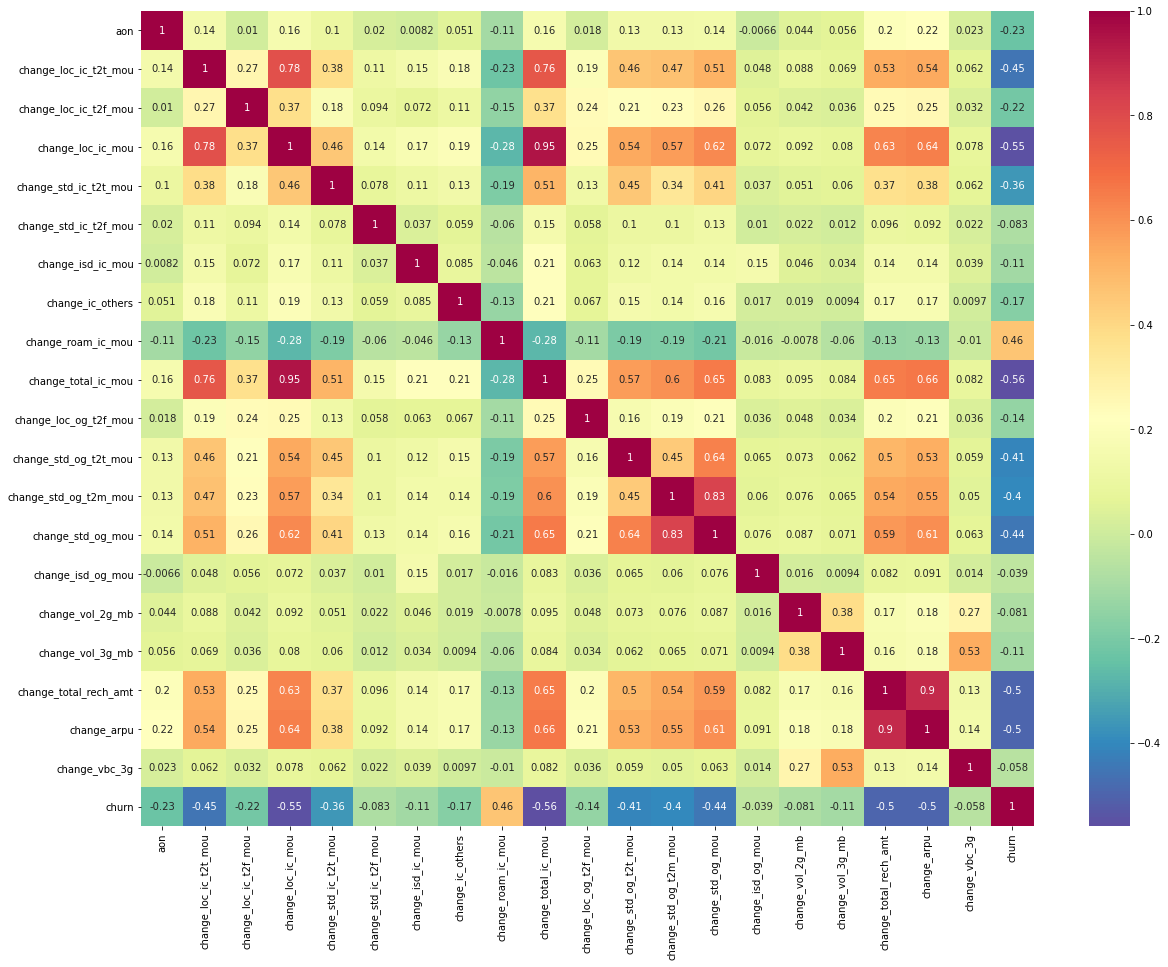

In [52]:
plt.figure(figsize=(20,15))
sns.heatmap(blncd_df[['aon', 'change_loc_ic_t2t_mou', 'change_loc_ic_t2f_mou',
       'change_loc_ic_mou', 'change_std_ic_t2t_mou', 'change_std_ic_t2f_mou',
       'change_isd_ic_mou', 'change_ic_others', 'change_roam_ic_mou',
       'change_total_ic_mou', 'change_loc_og_t2f_mou', 'change_std_og_t2t_mou',
       'change_std_og_t2m_mou', 'change_std_og_mou', 'change_isd_og_mou',
       'change_vol_2g_mb', 'change_vol_3g_mb', 'change_total_rech_amt',
       'change_arpu', 'change_vbc_3g','churn']].corr(),annot=True,cmap='Spectral_r')

**`Inference:`**
1. Customer is less likely to churn if their recharge amount and number of recharges is high.
2. Customer is less likely to churn if they have been on the network for a while (`aon` or age on network is high).
3. Total recharge amount and number of recharges increase if the customer uses Local network.
4. As the number of Local incoming and outgoing calls increase the customer is less likely to churn.
5. We can also see that columns `change_total_rech_num`, `change_max_rech_amt`, `change_total_rech_amt`, `change_arpu` are highly correlated.

## Feature Reduction  using  PCA

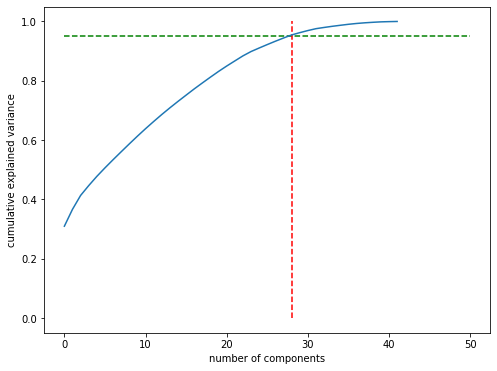

In [53]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver='randomized', random_state=101)
pca.fit(X_scaled)

fig = plt.figure(figsize = (8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.hlines(y=0.95, xmax=50, xmin=0, colors="g", linestyles="--")
plt.vlines(x=28, ymax=1, ymin=0, colors="r", linestyles="--")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

We are achieving 28 components for variance of 0.95

In [54]:
pca = PCA(n_components=28,random_state=100)

# fit_transform and transform to get the reduced data
X_pca = pca.fit_transform(X_scaled)

In [55]:
X_pca=pd.DataFrame(X_pca)
X_pca.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,-3.063792,0.155135,0.303829,-0.305757,0.185267,0.027508,-0.356913,0.071463,-0.891808,0.167677,-0.078397,0.118540,0.041421,-0.064961,-0.153666,-0.616795,-0.152519,-0.065670,0.321188,0.123089,0.381360,-0.734046,-0.184339,-0.231708,0.183637,-0.095821,0.025564,-0.264108
1,4.019926,-0.115484,-0.450324,-0.618875,0.157941,-1.155391,-1.123432,-0.033266,0.356886,0.928265,1.784180,1.390087,-0.932999,-1.843452,0.129686,-1.495275,-0.744740,0.719426,0.908155,-1.638759,2.263950,-0.104752,-0.306435,1.644428,-0.391145,-0.388908,0.132690,-0.443223
2,-4.945704,-0.604858,-0.666670,1.448565,-2.023039,-1.065958,1.301908,1.126029,2.616407,-0.706123,3.418894,1.061749,2.658396,0.464822,0.930876,0.130419,0.960193,0.187825,0.584629,1.207110,0.951725,0.106507,0.506731,-0.072592,-0.357314,0.361418,-0.612378,-0.326063
3,-5.070515,-0.012714,1.317135,0.255047,-0.068377,-0.341468,-0.548442,0.359038,-0.427598,0.195763,0.123372,0.257867,0.571646,0.294801,0.758222,0.283151,0.098653,-0.122490,0.369837,0.440139,-0.135155,0.183233,0.002451,-0.116091,0.144811,-0.177836,0.003429,0.180110
4,6.974530,-0.933041,0.302491,1.584101,0.271556,-0.563369,-1.376854,1.419268,-0.818465,1.116858,-2.066759,0.108563,0.414550,-0.054620,0.155300,2.701339,1.155944,0.358782,-0.251639,1.116800,0.685481,0.374709,-0.174512,0.612671,0.270843,-1.219034,0.556666,0.994432


In [56]:
X_pca.shape

(37819, 28)

## Logistic Regression to predict churned customers

In [57]:
X_train_sm = sm.add_constant(X_pca)
logm1 = sm.GLM(y_train.values.reshape(-1,1), X_train_sm, family = sm.families.Binomial())
res = logm1.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                37819
Model:                            GLM   Df Residuals:                    37790
Model Family:                Binomial   Df Model:                           28
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14564.
Date:                Sat, 03 Jul 2021   Deviance:                       29127.
Time:                        08:11:07   Pearson chi2:                 6.79e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0200      0.015     -1.341      0.1

As we see, column 27 has high p-value of 0.629. Hence, we can drop it.

In [58]:
X_pca.drop(27,axis=1,inplace=True)

In [59]:
X_train_sm = sm.add_constant(X_pca)
logm2 = sm.GLM(y_train.values.reshape(-1,1), X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                37819
Model:                            GLM   Df Residuals:                    37791
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14564.
Date:                Sat, 03 Jul 2021   Deviance:                       29127.
Time:                        08:11:08   Pearson chi2:                 6.79e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0200      0.015     -1.338      0.1

As we see, column 9 has high p-value of 0.519. Hence, we can drop it.

In [60]:
X_pca.drop(9,axis=1,inplace=True)

In [61]:
X_train_sm = sm.add_constant(X_pca)
logm3 = sm.GLM(y_train.values.reshape(-1,1), X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                37819
Model:                            GLM   Df Residuals:                    37792
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14564.
Date:                Sat, 03 Jul 2021   Deviance:                       29127.
Time:                        08:11:08   Pearson chi2:                 6.80e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0199      0.015     -1.335      0.1

In [62]:
# Calculating Variance Inflation Factor
def vif(X):
    vif=pd.DataFrame()

    vif['Features']=X.columns
    vif['vif']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['vif']=round(vif['vif'],2)
    vif=vif.sort_values(by='vif',ascending=False)
    return vif

In [63]:
# Checking VIF's
vif(X_pca)

,Features,vif
0,0,1.0
1,1,1.0
24,25,1.0
23,24,1.0
22,23,1.0
21,22,1.0
20,21,1.0
19,20,1.0
18,19,1.0
17,18,1.0


## Predicting on the test set

In [64]:
y_train_df=pd.DataFrame(y_train)
y_train_df.reset_index(drop=True, inplace=True)
y_train_pred = res.predict(X_train_sm)
y_train_df['churn_prob']= y_train_pred
y_train_df

,churn,churn_prob
0,1,0.843675
1,0,0.069456
2,1,0.977107
3,1,0.903543
4,0,0.015802
...,...,...
37814,0,0.021978
37815,1,0.911281
37816,1,0.910473
37817,0,0.210649


## Choose cut-off to be 0.5 for now

In [65]:
y_train_df['predicted'] = y_train_df['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

y_train_df.head()

,churn,churn_prob,predicted
0,1,0.843675,1
1,0,0.069456,0
2,1,0.977107,1
3,1,0.903543,1
4,0,0.015802,0


In [66]:
confusion_matrix = metrics.confusion_matrix(y_train_df['churn'], y_train_df['predicted'])
confusion_matrix

array([[16333,  2613],
       [ 2813, 16060]], dtype=int64)

In [67]:


def calculate_sensitivity(confusion_matrix):
    TP = confusion_matrix[1,1] #True Positive
    TN = confusion_matrix[0,0] #True Negative
    FP = confusion_matrix[0,1] #False Positive
    FN = confusion_matrix[1,0] #False Negative
    sensitivity = TP/float(TP + FN)
    return sensitivity

def calculate_accuracy(confusion_matrix):
    TP = confusion_matrix[1,1] #True Positive
    TN = confusion_matrix[0,0] #True Negative
    FP = confusion_matrix[0,1] #False Positive
    FN = confusion_matrix[1,0] #False Negative
    accuracy = (TP + TN)/float(TP + TN + FP + FN)
    return accuracy

def calculate_specificity(confusion_matrix):
    TP = confusion_matrix[1,1] #True Positive
    TN = confusion_matrix[0,0] #True Negative
    FP = confusion_matrix[0,1] #False Positive
    FN = confusion_matrix[1,0] #False Negative
    specificity = TN / (TN + FP)
    return specificity


**Note:-** In this case study we are concerned about predicting churn for high value customers. So, we want to identify them correctly and hence the model should have high sensitivity

In [68]:
print(calculate_sensitivity(confusion_matrix))
print(calculate_accuracy(confusion_matrix))

0.8509510941556722
0.8565271424416299


In [69]:
def draw_roc(actual, probability):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probability, drop_intermediate = False )
    
    auc_score = metrics.roc_auc_score( actual, probability )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

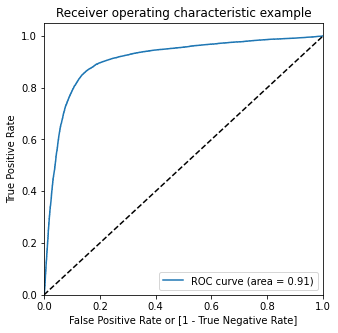

In [70]:
draw_roc(y_train_df['churn'], y_train_df['churn_prob'])

### Finding optimal cut-off

In [71]:
#Create columns with different probability cutoffs

numbers = [float(x) / 10 for x in range (10)]

for i in numbers:
    y_train_df[i] = y_train_df['churn_prob'].map(lambda x: 1 if x > i else 0)

y_train_df.head()

,churn,churn_prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.843675,1,1,1,1,1,1,1,1,1,1,0
1,0,0.069456,0,1,0,0,0,0,0,0,0,0,0
2,1,0.977107,1,1,1,1,1,1,1,1,1,1,1
3,1,0.903543,1,1,1,1,1,1,1,1,1,1,1
4,0,0.015802,0,1,0,0,0,0,0,0,0,0,0


In [72]:
#Create a DataFrame to hold all the cut-offs and their corresponding accuracy, sensitivity and specificity

cut_off_df = pd.DataFrame(columns=['probability','accuracy','sensitivity','specificity'])

for i in numbers:
    confusion_matrix_cut_off = metrics.confusion_matrix(y_train_df['churn'], y_train_df[i])
    accuracy = calculate_accuracy(confusion_matrix_cut_off)
    sensitivity = calculate_sensitivity(confusion_matrix_cut_off)
    specificity = calculate_specificity(confusion_matrix_cut_off)
    cut_off_df.loc[i] = [i, accuracy, sensitivity, specificity]

cut_off_df

,probability,accuracy,sensitivity,specificity
0.0,0.0,0.499035,1.000000,0.000000
0.1,0.1,0.671620,0.971229,0.373166
0.2,0.2,0.777255,0.944153,0.611000
0.3,0.3,0.829001,0.916071,0.742267
0.4,0.4,0.852085,0.888677,0.815634
0.5,0.5,0.856527,0.850951,0.862082
0.6,0.6,0.848224,0.803688,0.892589
0.7,0.7,0.830191,0.742383,0.917661
0.8,0.8,0.785822,0.625974,0.945054
0.9,0.9,0.683968,0.393896,0.972923


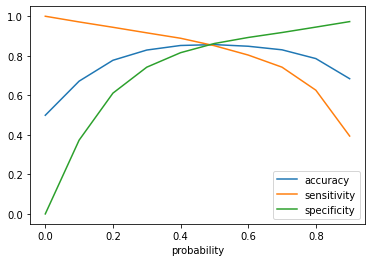

In [73]:
#Plotting accuracy, sensitivity, specificity for various cut-offs
cut_off_df.plot.line(x = 'probability', y = ['accuracy','sensitivity','specificity'])
plt.show()

**Our initial cut-off probability was correct so we take 0.5 as the cut-off probability**

In [74]:
y_train_df['final_predicted'] = y_train_df['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)
y_train_df

,churn,churn_prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.843675,1,1,1,1,1,1,1,1,1,1,0,1
1,0,0.069456,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.977107,1,1,1,1,1,1,1,1,1,1,1,1
3,1,0.903543,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0.015802,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37814,0,0.021978,0,1,0,0,0,0,0,0,0,0,0,0
37815,1,0.911281,1,1,1,1,1,1,1,1,1,1,1,1
37816,1,0.910473,1,1,1,1,1,1,1,1,1,1,1,1
37817,0,0.210649,0,1,1,1,0,0,0,0,0,0,0,0


In [75]:
y_train_df.final_predicted.value_counts()

0    19146
1    18673
Name: final_predicted, dtype: int64

In [76]:
confusion_matrix_logistic = metrics.confusion_matrix(y_train_df['churn'], y_train_df['final_predicted'])

print("Accuracy = ", calculate_accuracy(confusion_matrix_logistic))
print("Sensitivity = ", calculate_sensitivity(confusion_matrix_logistic))
print("Specificity = ", calculate_specificity(confusion_matrix_logistic))

Accuracy =  0.8565271424416299
Sensitivity =  0.8509510941556722
Specificity =  0.8620817059009818


## Predicting on test set

In [77]:
#scaling the test set
X_test_scaled=scaler.transform(X_test)

#PCA on test set
X_test_pca = pca.transform(X_test_scaled)

X_test_pca = pd.DataFrame(X_test_pca)

X_test_pca

#Dropping below columns as we dropped them from train set as well (due to high p value)
X_test_pca.drop(27,axis=1,inplace=True)
X_test_pca.drop(9,axis=1,inplace=True)

#adding constant
X_test_sm = sm.add_constant(X_test_pca)

#predicting
y_test_pred = res.predict(X_test_sm)

#creating a DataFrame from the prediction
y_test_pred_df = pd.DataFrame(y_test_pred)

#resetting the index
y_test_pred_df.reset_index(drop=True, inplace=True)

#Renaming the column
y_test_pred_df = y_test_pred_df.rename(columns={0:'churn_prob'})

#creating y_test_df
y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(drop=True, inplace=True)
y_test_pred_df = y_test_pred_df.rename(columns={0:'churn'})

#Adding test churn column
y_test_pred_df = pd.concat([y_test_df,y_test_pred_df],axis=1)

y_test_pred_df

,churn,churn_prob
0,1,0.896120
1,1,0.962402
2,0,0.731486
3,0,0.474404
4,1,0.938908
...,...,...
16204,0,0.425183
16205,0,0.537519
16206,0,0.445227
16207,0,0.026550


In [78]:
#Predicting final values
y_test_pred_df["final_predicted"] = y_test_pred_df['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_df


,churn,churn_prob,final_predicted
0,1,0.896120,1
1,1,0.962402,1
2,0,0.731486,1
3,0,0.474404,0
4,1,0.938908,1
...,...,...,...
16204,0,0.425183,0
16205,0,0.537519,1
16206,0,0.445227,0
16207,0,0.026550,0


In [79]:
#Creating confusion matrix
confusion_matrix_test = metrics.confusion_matrix(y_test_pred_df['churn'],y_test_pred_df['final_predicted'])
confusion_matrix_test

array([[6939, 1129],
       [1245, 6896]], dtype=int64)

In [80]:
#Prinitind model metrics
print("Final Accuracy = ", calculate_accuracy(confusion_matrix_test))
print("Final Sensitivity = ", calculate_sensitivity(confusion_matrix_test))
print("Final Specificity = ", calculate_specificity(confusion_matrix_test))

Final Accuracy =  0.8535381578135603
Final Sensitivity =  0.8470703844736519
Final Specificity =  0.8600644521566683


## Decision Tree Model

In [81]:
dt = DecisionTreeClassifier(max_depth=3,random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [82]:
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz

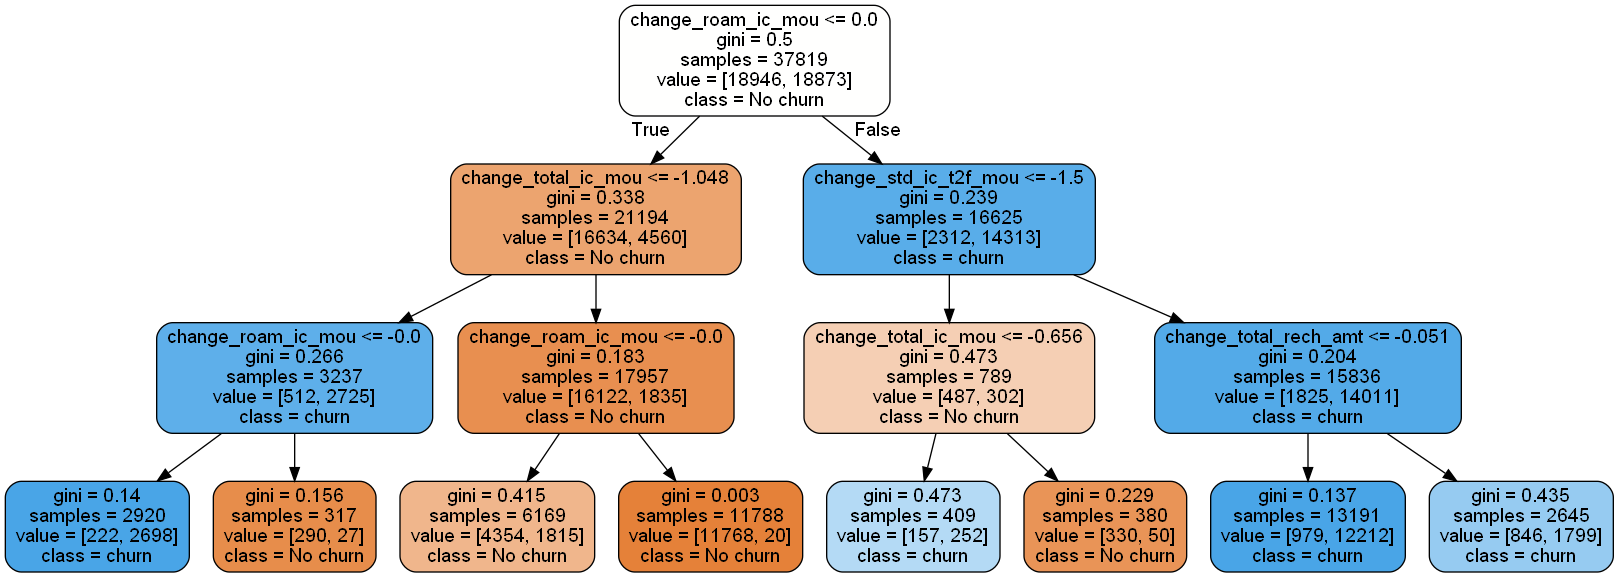

In [83]:
# plotting tree with max_depth=3
dot_data = StringIO()  

export_graphviz(dt, out_file=dot_data, filled=True, rounded=True,
                feature_names=X.columns, 
                class_names=['No churn', 'churn'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# Image(graph.create_png(),width=800,height=900)
# graph.write_pdf("dt_heartdisease.pdf")

In [105]:
#To run grid searchcv
def run_grid_search(params):
    #Instantiate DT classifier
    dt = DecisionTreeClassifier(random_state=42)

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

    #Fit on the data set
    grid_search.fit(X_train, y_train)

    #Creating a DataFrame to store the grid search results
    score_df = pd.DataFrame(grid_search.cv_results_)
    
    #Returning the top 10 Decision trees
   # return score_df.nlargest(10,"mean_test_score")
    return score_df

def plot_max_depth(score_df, criterion, min_samples_leaf, min_samples_split):
    plt.plot(score_df[(score_df['param_criterion'] == criterion)& (score_df['param_min_samples_leaf'] == min_samples_leaf) & (score_df['param_min_samples_split'] == min_samples_split)]["param_max_depth"], 
         score_df[(score_df['param_criterion'] == criterion) & (score_df['param_min_samples_leaf'] == min_samples_leaf) & (score_df['param_min_samples_split'] == min_samples_split)]["mean_test_score"], 
         label="test accuracy")
    plt.xlabel("param_max_depth")
    plt.ylabel("Accuracy")
    plt.legend()

def plot_min_samples_leaf(score_df, criterion, max_depth, min_samples_split):
    plt.plot(score_df[(score_df['param_criterion'] == criterion)& (score_df['param_max_depth'] == max_depth) & (score_df['param_min_samples_split'] == min_samples_split)]["param_min_samples_leaf"], 
         score_df[(score_df['param_criterion'] == criterion) & (score_df['param_max_depth'] == max_depth) & (score_df['param_min_samples_split'] == min_samples_split)]["mean_test_score"], 
         label="test accuracy")
    plt.xlabel("min_samples_leaf")
    plt.ylabel("Accuracy")
    plt.legend()

def plot_min_samples_split(score_df, criterion, min_samples_leaf, max_depth):
    plt.plot(score_df[(score_df['param_criterion'] == criterion)& (score_df['param_min_samples_leaf'] == min_samples_leaf) & (score_df['param_max_depth'] == max_depth)]["param_min_samples_split"], 
            score_df[(score_df['param_criterion'] == criterion) & (score_df['param_min_samples_leaf'] == min_samples_leaf) & (score_df['param_max_depth'] == max_depth)]["mean_test_score"], 
            label="test accuracy")
    plt.xlabel("param_min_samples_split")
    plt.ylabel("Accuracy")
    plt.legend()

def plot_scatter_max_depth(score_df, criterion, min_samples_leaf, min_samples_split):
    plt.scatter(data = score_df[(score_df['param_criterion'] == criterion)& (score_df['param_min_samples_leaf'] == min_samples_leaf) & (score_df['param_min_samples_split'] == min_samples_split)], x = "param_max_depth" ,y = "mean_test_score")
    plt.xlabel("param_max_depth")
    plt.ylabel("Accuracy")
    plt.legend()

def plot_scatter_min_samples_leaf(score_df, criterion, max_depth, min_samples_split):
    plt.scatter(data = score_df[(score_df['param_criterion'] == criterion)& (score_df['param_max_depth'] == max_depth) & (score_df['param_min_samples_split'] == min_samples_split)], x = "param_min_samples_leaf", y = "mean_test_score")
    plt.xlabel("min_samples_leaf")
    plt.ylabel("Accuracy")
    plt.legend()

def plot_scatter_min_samples_split(score_df, criterion, min_samples_leaf, max_depth):
    plt.scatter(data = score_df[(score_df['param_criterion'] == criterion)& (score_df['param_min_samples_leaf'] == min_samples_leaf) & (score_df['param_max_depth'] == max_depth)], x = "param_min_samples_split", y = "mean_test_score")
    plt.xlabel("param_min_samples_split")
    plt.ylabel("Accuracy")
    plt.legend()

In [85]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_leaf': [50, 100,200,300,500],
    'criterion': ["gini", "entropy"],
    'min_samples_split':[50,100,200,300,500]
}

dt_df_1 = run_grid_search(params)
dt_df_1.nlargest(10,"mean_test_score")

Fitting 4 folds for each of 200 candidates, totalling 800 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
177,3.950779,0.518900,0.023369,0.012544,entropy,10,50,200,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.940455,0.936436,0.942464,0.940237,0.939898,0.002179,1
178,4.124992,0.500496,0.011164,0.000698,entropy,10,50,300,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.941089,0.934638,0.942887,0.940025,0.939660,0.003075,2
179,3.005455,0.375860,0.017789,0.006630,entropy,10,50,500,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.941089,0.934638,0.942887,0.938862,0.939369,0.003081,3
175,2.954498,0.334204,0.014692,0.003386,entropy,10,50,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.940455,0.936013,0.941512,0.939391,0.939343,0.002064,4
176,3.342300,0.399046,0.014069,0.001838,entropy,10,50,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.940455,0.936013,0.941512,0.939391,0.939343,0.002064,4
75,1.897001,0.187813,0.011630,0.000886,gini,10,50,50,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.939080,0.935695,0.934215,0.941718,0.937677,0.002924,6
76,1.798744,0.194774,0.012106,0.000768,gini,10,50,100,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.939080,0.935695,0.934215,0.941718,0.937677,0.002924,6
77,1.756653,0.169272,0.012643,0.002072,gini,10,50,200,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.937282,0.933263,0.934109,0.939285,0.935985,0.002424,8
78,1.782595,0.140190,0.013855,0.002440,gini,10,50,300,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.938022,0.931465,0.934955,0.937804,0.935562,0.002657,9
79,1.887637,0.315004,0.031058,0.018640,gini,10,50,500,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.932840,0.929878,0.933369,0.935583,0.932917,0.002034,10


### Plotting various hyperparameters to see how accuracy is affected

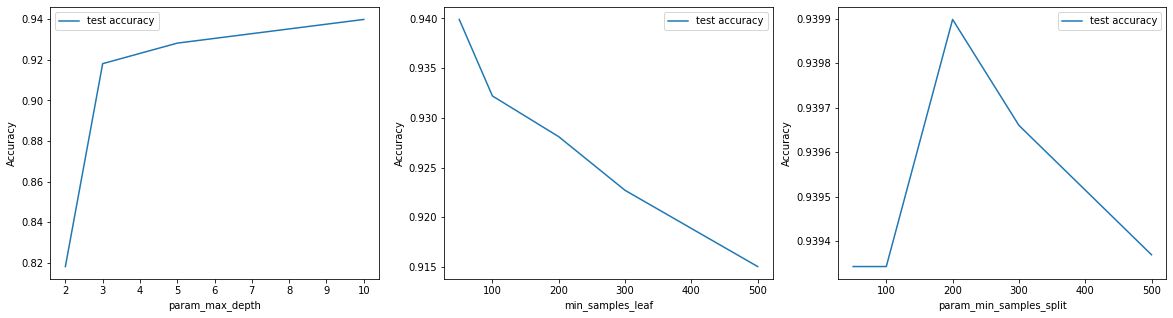

In [86]:
#Plotting the change in accuracy with the change in min_samples_leaf

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
#plot_scatter_max_depth(dt_df_1, "entropy", 50, 200)
plot_max_depth(dt_df_1, "entropy", 50, 200)

plt.subplot(1,3,2)
#plot_scatter_min_samples_leaf(dt_df_1, "entropy", 50, 200)
plot_min_samples_leaf(dt_df_1, "entropy", 10, 200)

plt.subplot(1,3,3)
#plot_scatter_min_samples_split(dt_df_1, "entropy", 50, 10)
plot_min_samples_split(dt_df_1, "entropy", 50, 10)

plt.show()


### Based on what we observed above, we now tweak the hyperparameters around the values we took for the top model

In [87]:
# Create the parameter grid based on the results of previous random search 
params_2 = {
    'max_depth': [9,10,11,12],
    'min_samples_leaf': [40,50,60,70],
    'criterion': ["gini", "entropy"],
    'min_samples_split':[150,170,190,200,210,230]
}

dt_df_2 = run_grid_search(params_2)
dt_df_2.nlargest(10,"mean_test_score")


Fitting 4 folds for each of 192 candidates, totalling 768 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
173,4.025176,0.236634,0.015112,0.003856,entropy,12,40,230,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.941618,0.938657,0.944262,0.944256,0.942198,0.002312,1
171,3.774447,0.505439,0.025931,0.018995,entropy,12,40,200,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.941195,0.937811,0.944262,0.944045,0.941828,0.002616,2
172,3.943529,0.297089,0.016138,0.002577,entropy,12,40,210,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.941195,0.937811,0.944262,0.944045,0.941828,0.002616,2
170,3.144414,0.230387,0.014037,0.000639,entropy,12,40,190,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.940984,0.937811,0.944262,0.944045,0.941775,0.002631,4
149,3.687315,0.107015,0.020380,0.013544,entropy,11,40,230,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.942041,0.937705,0.943733,0.943304,0.941696,0.002387,5
169,3.607195,0.346516,0.014520,0.002803,entropy,12,40,170,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.940137,0.937811,0.944262,0.944045,0.941564,0.002718,6
168,3.882948,0.213300,0.014097,0.001825,entropy,12,40,150,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.940032,0.936965,0.944368,0.944256,0.941405,0.003103,7
147,3.044674,0.216037,0.015229,0.003617,entropy,11,40,200,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.941618,0.936859,0.943733,0.943093,0.941326,0.002691,8
148,2.892975,0.131527,0.017119,0.007243,entropy,11,40,210,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.941618,0.936859,0.943733,0.943093,0.941326,0.002691,8
146,2.811672,0.187302,0.012338,0.001195,entropy,11,40,190,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.941407,0.936859,0.943733,0.943093,0.941273,0.002686,10


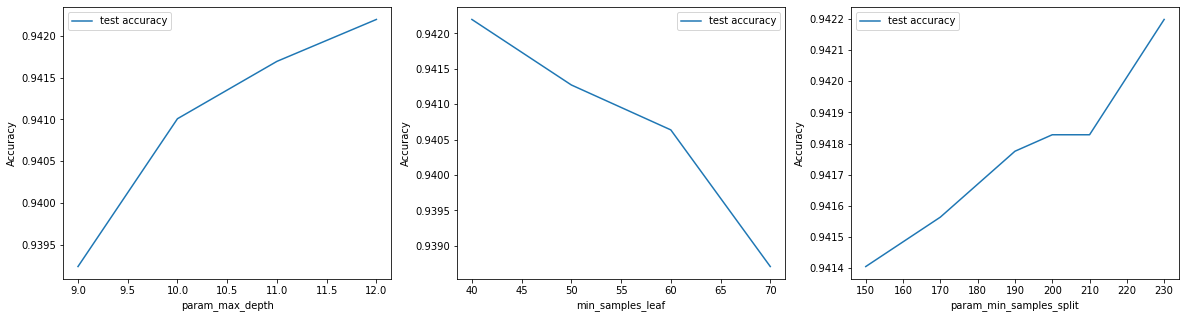

In [88]:
#Plotting the change in accuracy with the change in min_samples_split

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
#plot_scatter_max_depth(dt_df_2, "entropy", 40, 230)
plot_max_depth(dt_df_2, "entropy", 40, 230)

plt.subplot(1,3,2)
#plot_scatter_min_samples_leaf(dt_df_2, "entropy", 12, 230)
plot_min_samples_leaf(dt_df_2, "entropy", 12, 230)

plt.subplot(1,3,3)
#plot_scatter_min_samples_split(dt_df_2, "entropy", 40, 12)
plot_min_samples_split(dt_df_2, "entropy", 40, 12)

plt.show()

In [89]:
# Create the new parameter grid based on the results of previous random search 
params_3 = {
    'max_depth': [10,11],
    'min_samples_leaf': [40,50,60,70],
    'criterion': ["gini", "entropy"],
    'min_samples_split':[150,170,190,200,210,230]
}

dt_df_3 = run_grid_search(params_3)
dt_df_3.nlargest(10,"mean_test_score")

Fitting 4 folds for each of 96 candidates, totalling 384 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
77,3.313201,0.150754,0.014221,0.002387,entropy,11,40,230,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.942041,0.937705,0.943733,0.943304,0.941696,0.002387,1
75,4.317199,0.273419,0.013773,0.001583,entropy,11,40,200,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.941618,0.936859,0.943733,0.943093,0.941326,0.002691,2
76,3.751772,0.330887,0.014630,0.002974,entropy,11,40,210,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.941618,0.936859,0.943733,0.943093,0.941326,0.002691,2
74,3.460006,0.539308,0.022186,0.010983,entropy,11,40,190,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.941407,0.936859,0.943733,0.943093,0.941273,0.002686,4
72,3.205505,0.382709,0.012259,0.000741,entropy,11,40,150,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.940455,0.936859,0.943839,0.943304,0.941114,0.002773,5
73,3.501952,0.485920,0.025348,0.016535,entropy,11,40,170,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.940561,0.936859,0.943733,0.943093,0.941061,0.002701,6
53,3.369728,0.305920,0.031364,0.019367,entropy,10,40,230,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.942041,0.937599,0.941512,0.942881,0.941009,0.002028,7
51,3.796788,0.799690,0.016555,0.004183,entropy,10,40,200,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.941618,0.936753,0.941512,0.942670,0.940638,0.002288,8
52,3.790481,0.236898,0.019519,0.004919,entropy,10,40,210,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.941618,0.936753,0.941512,0.942670,0.940638,0.002288,8
50,3.776391,0.391145,0.021729,0.010216,entropy,10,40,190,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.941407,0.936753,0.941512,0.942670,0.940585,0.002267,10


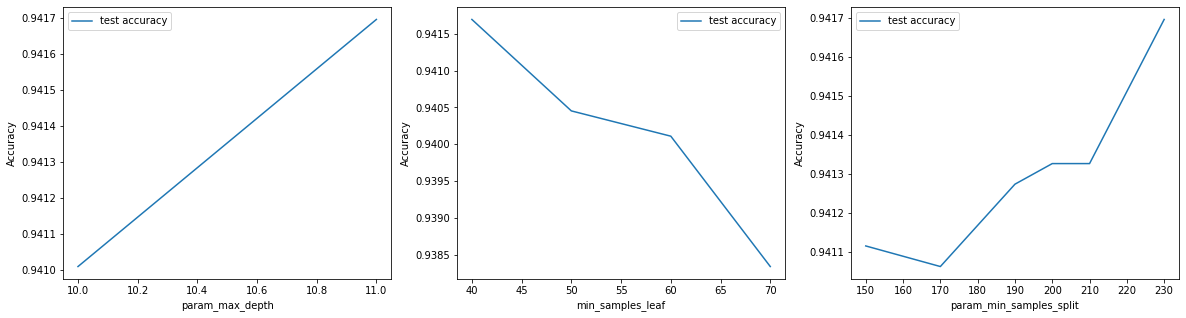

In [90]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plot_max_depth(dt_df_3, "entropy", 40, 230)

plt.subplot(1,3,2)
plot_min_samples_leaf(dt_df_3, "entropy", 11, 230)

plt.subplot(1,3,3)
plot_min_samples_split(dt_df_3, "entropy", 40, 11)

plt.legend()
plt.show()

In [106]:
# Create the new parameter grid based on the results of previous random search 
params_4 = {
    'max_depth': [10],
    'min_samples_leaf': [40],
    'criterion': ["entropy"],
    'min_samples_split':[200,202,204,206,208,210]
}

dt_df_4 = run_grid_search(params_4)
dt_df_4.nlargest(10,"mean_test_score")

Fitting 4 folds for each of 6 candidates, totalling 24 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,2.351261,0.174416,0.011248,0.001274,entropy,10,40,200,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.941618,0.936753,0.941512,0.94267,0.940638,0.002288,1
1,2.366027,0.207874,0.018523,0.009229,entropy,10,40,202,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.941618,0.936753,0.941512,0.94267,0.940638,0.002288,1
2,2.629134,0.234043,0.012872,0.001498,entropy,10,40,204,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.941618,0.936753,0.941512,0.94267,0.940638,0.002288,1
3,3.039721,0.391908,0.013175,0.000128,entropy,10,40,206,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.941618,0.936753,0.941512,0.94267,0.940638,0.002288,1
4,3.027343,0.549656,0.032910,0.012778,entropy,10,40,208,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.941618,0.936753,0.941512,0.94267,0.940638,0.002288,1
5,3.553371,0.355587,0.013856,0.002263,entropy,10,40,210,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.941618,0.936753,0.941512,0.94267,0.940638,0.002288,1


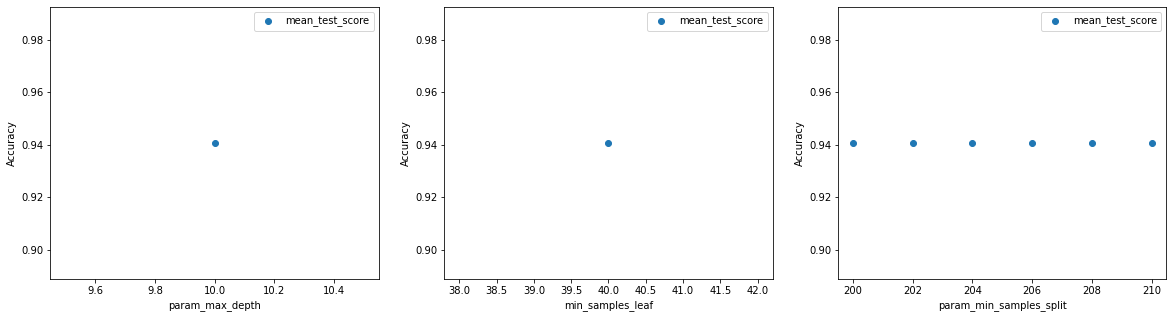

In [92]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plot_scatter_max_depth(dt_df_4, "entropy", 40, 200)
#plot_max_depth(dt_df_4, "entropy", 40, 200)

plt.subplot(1,3,2)
plot_scatter_min_samples_leaf(dt_df_4, "entropy", 10, 200)
#plot_min_samples_leaf(dt_df_4, "entropy", 10, 210)

plt.subplot(1,3,3)
plot_scatter_min_samples_split(dt_df_4, "entropy", 40, 10)
#plot_min_samples_split(dt_df_4, "entropy", 40, 10)

plt.show()

In [93]:
# Going forward with the top model which has max_depth = 10, min_samples_leaf = 40 and min_samples_split = 200
dt = DecisionTreeClassifier(max_depth = 10, criterion = 'entropy', min_samples_leaf = 40, random_state = 42, min_samples_split = 200)
dt.fit(X_train, y_train)

# plotting tree with max_depth = 10
dot_data = StringIO()  

export_graphviz(dt, out_file=dot_data, filled=True, rounded=True,
                feature_names=X.columns, 
                class_names=['No churn', 'churn'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
Image(graph.create_png(),width=800,height=900)
graph.write_pdf("dt_telecomchurn.pdf")

True

In [94]:
#Defining a function to evalute model
def evaluate_model(dt_classifier):
    print("Train Accuracy :", metrics.accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(metrics.confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", metrics.accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(metrics.confusion_matrix(y_test, dt_classifier.predict(X_test)))

In [95]:
#Evaluating our best DT
evaluate_model(dt)

Train Accuracy : 0.9475660382347497
Train Confusion Matrix:
[[17309  1637]
 [  346 18527]]
--------------------------------------------------
Test Accuracy : 0.94256277376766
Test Confusion Matrix:
[[7335  733]
 [ 198 7943]]


In [96]:
#Checking the final metrics
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      8068
           1       0.92      0.98      0.94      8141

    accuracy                           0.94     16209
   macro avg       0.94      0.94      0.94     16209
weighted avg       0.94      0.94      0.94     16209



## Random Forest

In [97]:
def run_grid_search_rf(params):
    #Instantiate RF classifier
    rf = RandomForestClassifier(random_state = 34)

    #Instantiate the grid search 
    grid_search = GridSearchCV(estimator = rf, param_grid = params, cv = 4, n_jobs = -1, verbose = 1, scoring = "accuracy")

    #Fit on the data set
    grid_search.fit(X_train, y_train)

    #Creating a DataFrame to store the grid search results
    score_df = pd.DataFrame(grid_search.cv_results_)

    #get the best RF
    rf_best = grid_search.best_estimator_
    print(rf_best)

    #Plot ROC curve
    metrics.plot_roc_curve(rf_best, X_train, y_train)
    plt.show()

    #return score_df.nlargest(10,"mean_test_score")
    return score_df


Fitting 4 folds for each of 180 candidates, totalling 720 fits
RandomForestClassifier(max_depth=12, min_samples_leaf=50, min_samples_split=50,
                       n_estimators=70, random_state=34)


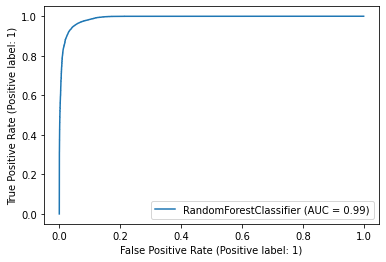

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
124,17.249654,0.992607,0.227633,0.027669,12,50,50,70,"{'max_depth': 12, 'min_samples_leaf': 50, 'min...",0.938551,0.935167,0.940137,0.943410,0.939316,0.002968,1
129,15.895568,0.777185,0.246994,0.026760,12,50,75,70,"{'max_depth': 12, 'min_samples_leaf': 50, 'min...",0.938551,0.935167,0.940137,0.943410,0.939316,0.002968,1
134,18.649592,1.135917,0.311621,0.031523,12,50,100,70,"{'max_depth': 12, 'min_samples_leaf': 50, 'min...",0.938551,0.935167,0.940137,0.943410,0.939316,0.002968,1
123,14.082752,0.998257,0.185206,0.006078,12,50,50,60,"{'max_depth': 12, 'min_samples_leaf': 50, 'min...",0.938128,0.934744,0.938657,0.942670,0.938550,0.002813,4
128,13.782295,0.420017,0.242257,0.026222,12,50,75,60,"{'max_depth': 12, 'min_samples_leaf': 50, 'min...",0.938128,0.934744,0.938657,0.942670,0.938550,0.002813,4
133,14.823057,1.578870,0.306674,0.153579,12,50,100,60,"{'max_depth': 12, 'min_samples_leaf': 50, 'min...",0.938128,0.934744,0.938657,0.942670,0.938550,0.002813,4
120,7.176851,0.663379,0.135757,0.015177,12,50,50,30,"{'max_depth': 12, 'min_samples_leaf': 50, 'min...",0.938445,0.934426,0.939397,0.940554,0.938206,0.002306,7
125,6.561983,0.329048,0.105524,0.019402,12,50,75,30,"{'max_depth': 12, 'min_samples_leaf': 50, 'min...",0.938445,0.934426,0.939397,0.940554,0.938206,0.002306,7
130,7.252572,0.200144,0.108322,0.013336,12,50,100,30,"{'max_depth': 12, 'min_samples_leaf': 50, 'min...",0.938445,0.934426,0.939397,0.940554,0.938206,0.002306,7
121,9.864013,0.965499,0.171158,0.035348,12,50,50,40,"{'max_depth': 12, 'min_samples_leaf': 50, 'min...",0.938657,0.935378,0.937493,0.941083,0.938153,0.002060,10


In [108]:
params = {
    'max_depth': [10,11,12],
    'min_samples_leaf': [50,60,70,80],
    'n_estimators': [30,40,50,60,70],
    'min_samples_split': [50,75,100]
}

rf_df_1 = run_grid_search_rf(params)
rf_df_1.nlargest(10,"mean_test_score")

In [109]:
#Creating Random Forest Classifier based on above tuning
rf = RandomForestClassifier(max_depth=12, min_samples_leaf=50, min_samples_split=50, n_estimators=70,random_state = 34)

#Fit on training data
rf.fit(X_train, y_train)

#Evaluating the best RF
evaluate_model(rf)


Train Accuracy : 0.949787144028134
Train Confusion Matrix:
[[17581  1365]
 [  534 18339]]
--------------------------------------------------
Test Accuracy : 0.9460176445184774
Test Confusion Matrix:
[[7483  585]
 [ 290 7851]]


In [110]:
#Checking the final metrics
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      8068
           1       0.93      0.96      0.95      8141

    accuracy                           0.95     16209
   macro avg       0.95      0.95      0.95     16209
weighted avg       0.95      0.95      0.95     16209



## Comparing all three models

In [118]:

metrics_df = pd.DataFrame({"Model" : ["Logistic Regression","Decision Tree","Random Forest"],
                            "Train Accuracy" : [calculate_accuracy(confusion_matrix_logistic), metrics.accuracy_score(y_train, dt.predict(X_train)), metrics.accuracy_score(y_train, rf.predict(X_train))],
                            "Test Accuracy" : [calculate_accuracy(confusion_matrix_test), metrics.accuracy_score(y_test, dt.predict(X_test)), metrics.accuracy_score(y_test, rf.predict(X_test))]})

metrics_df

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.856527,0.853538
1,Decision Tree,0.947566,0.942563
2,Random Forest,0.949787,0.946018


**Observations**
- Decision Tree and  Random Forest have much better accuracy than Logistic Regression
- Random Forest and Decision Tree have almost the same accuracy
- **We choose Random Forest** because although it has almost the same accuracy as Decision Tree, it is a collection of Decision Trees, so we can trust it better

In [119]:
#Displaying top features to be considered about every customer
rfe_cols

Index(['aon', 'total_rech_amt_good_phase', 'change_offnet_mou',
       'change_loc_ic_t2t_mou', 'change_loc_ic_t2m_mou',
       'change_std_ic_t2t_mou', 'change_roam_ic_mou', 'change_total_ic_mou',
       'change_loc_og_t2m_mou', 'change_loc_og_mou', 'change_std_og_t2t_mou',
       'change_og_others', 'change_roam_og_mou', 'change_total_og_mou',
       'change_vol_3g_mb', 'change_total_rech_num', 'change_max_rech_amt',
       'change_total_rech_amt', 'change_arpu', 'change_vbc_3g'],
      dtype='object')

**Observations/Business suggestions**
- Age on Network (aon) to be considered for a customer to understand their behaviour
- We basically need to understand the change in a customer's service usage in the action phase, (i.e. reduction/addition in recharges, recharge amounts, local, std and roaming calls, internet usage etc) in order to understand their behaviour
- Also, for every user, we need to understand the average revenue they are bringing to the company and if there is a change in it, in the action phase

Customers will churn out due to some or all of the following reasons:
1. Poor network coverage
2. High call/recharge rates
3. Better offers by the competition
4. Better offers on high value services such as ISD calls
5. Sometimes there are family pack kind of offers, so a user will switch to the provider which has those kind of offers